# Default Risk Exploratory Data Analysis

## General Info

* There are nine different datasets that can be used for this analysis
* All nine together are more than 2 gigabytes of data
  * Each has up to hundreds of features and hundreds of thousands, some with millions, of rows

*It will be important to utilize the data in a computationally efficient way, while still generating the most accurate model possible*

## Imports

In [1]:
# Import pandas

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


**The following function will allow me to quickly return correlation between whichever feature I choose and every other feature in the dataset. It is set to return absolute values, so the "largest" correlations will be returned first. It also shows the missing values % in the second column**

In [2]:
# Create correlation/missing values function

def abs_corr(df, df_col):
  corr_mat = df.select_dtypes(include='number').corr()
  col_corr = corr_mat[df_col].abs().sort_values(ascending = False)
  missing_percentages = df.isnull().mean()
  result = col_corr.head(20).to_frame(name='Correlation')
  result['Missing Percentage'] = missing_percentages[result.index]
  return result

## Train Application

* I will start with the train application first as this holds the most recent application, target variables, and same features as test set
* SK_ID_CURR is the primary identifier
* Each row represents a loan

### *General Analysis*

In [3]:
# Read dataset to CSV

train_app = pd.read_csv('Data/Raw_Data/application_train.csv')

In [4]:
# Info check

train_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


**Train application has 122 columns and 307511 rows**

In [5]:
# header check

train_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# First I will do a duplicate check

print(f'Number of duplicate entries - {train_app.duplicated().sum()}')

Number of duplicate entries - 0


**I will drop all columns with any amount of nulls. I will add columns back based on correlation to the target as a fast and easy way to determine importance**

In [7]:
# Drop columns with nulls

train_0null = train_app.isna().sum() == 0
train_0null_df = train_app.loc[:, train_0null]
print(f'Train App shape after dropping columns with nulls - {train_0null_df.shape}')

Train App shape after dropping columns with nulls - (307511, 55)


In [8]:
# Check that the correct columns were dropped and maintained

print(f'Train App nulls after dropping columns with nulls - {train_0null_df.isna().sum().sum()}')

Train App nulls after dropping columns with nulls - 0


**Since there are still 55 columns and more than 550 rows (10x columns), I am comfortable moving forward with this information as a starting point**

### *Features*

#### TARGET

* 1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in the sample
* 0 - all other cases
* Default rate in sample - 8.07%

In [9]:
# Take a quick look at correlation between TARGET and every other numerical feature

abs_corr(train_app, 'TARGET')

,Correlation,Missing Percentage
TARGET,1.000000,0.000000
EXT_SOURCE_3,0.178919,0.198253
EXT_SOURCE_2,0.160472,0.002146
EXT_SOURCE_1,0.155317,0.563811
DAYS_BIRTH,0.078239,0.000000
REGION_RATING_CLIENT_W_CITY,0.060893,0.000000
REGION_RATING_CLIENT,0.058899,0.000000
DAYS_LAST_PHONE_CHANGE,0.055218,0.000003
DAYS_ID_PUBLISH,0.051457,0.000000
REG_CITY_NOT_WORK_CITY,0.050994,0.000000


**EXT_SOURCE features have highest correlations to target. Will take note and add back later since these columns were dropped**

In [10]:
# What is the rate of default (Target = 1) for the entire set

print(f'Default Rate in Train Application - {round(train_app['TARGET'].mean()* 100, 2)}%')

Default Rate in Train Application - 8.07%


#### AMT_ANNUITY

* Represents monthly loan payment
* 12 nulls
* I will assume monthly payment amount is relevant to the model and add back to dataset
* Will impute nulls in preprocess with median imputer

In [11]:
# Check number of nulls

print(f'Nulls in AMT_ANNUITY column - {train_app['AMT_ANNUITY'].isna().sum()}')

Nulls in AMT_ANNUITY column - 12


**12 nulls out of 300,000+ rows is negligible, will add back to dataset**

In [12]:
# Create dataframe with annuity amount and SK_ID_CURR column to merge back to ) null set

annuity_df = train_app[['AMT_ANNUITY', 'SK_ID_CURR']]
annuity_df.head()


,AMT_ANNUITY,SK_ID_CURR
0,24700.5,100002
1,35698.5,100003
2,6750.0,100004
3,29686.5,100006
4,21865.5,100007


In [13]:
# Merge back to 0 null dataset and info check to make sure it merged correctly

train_0null_df = pd.merge(train_0null_df, annuity_df, how='left', on='SK_ID_CURR')
train_0null_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 56 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   NAME_INCOME_TYPE             307511 non-null  object 
 10  NAME_EDUCATION_TYPE          307511 non-null  object 
 11  NAME_FAMILY_STATUS           307511 non-null  object 
 12  NAME_HOUSING_TYPE            307511 non-null  object 
 13 

**There are no nulls for now except for the AMT_ANNUITY column. Look at the object columns to determine how to treat them in preprocess**


In [14]:
# What are the object columns?

train_0null_df.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

#### NAME_CONTRACT_TYPE

* Type of loan 
* Two separate values
* 0 nulls
* Approx 9% are Revolving loan and the other 91% are cash loans
* One hot encode

In [15]:
# Look at value counts

train_0null_df['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

#### CODE_GENDER

* Gender
* 0 nulls
* Three values - M, F and XNA
* Only 4 values in XNA, will drop in preprocess
* One hot encode

In [16]:
# Look at value counts

train_0null_df['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

#### FLAG_OWN_CAR

* Does client own car?
* Two values - Yes/No
* 0 nulls
* One hot encode

In [17]:
# Look at values counts

train_0null_df['FLAG_OWN_CAR'].value_counts()

FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

#### FLAG_OWN_REALTY

* Does client own realty?
* 0 nulls
* Two values - Yes/No
* Will encode to No = 0 and Yes = 1

In [18]:
# Look at values counts

train_0null_df['FLAG_OWN_REALTY'].value_counts()

FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64

#### NAME_INCOME_TYPE

* Type of income
* 0 nulls
* Eight unique values
  * Maternity leave (5 instances), Student (18), Businessman(10) and Unemployed (22) have small number of occurences
* Will combine these with other columns as follows to avoid redundancy and  :
  * Maternity Leave --> Working
  * Student --> Unemployed
  * Businessman --> Working
  * Unemployed --> No change
* One hot encode

In [19]:
# Look at values counts

train_0null_df['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

#### NAME_EDUCATION_TYPE

* Highest level of education achieved
* 0 nulls
* Five unique values
  * Higher Education and Academic Degree are redundant, will combine into Higher Education
  * Incomplete higher, and secondary are redundant. Both mean HS diploma highest education completed
    *Will combine into one column "Secondary" in preprocess
  * Will keep lower secondary as is, since this means no high school diploma
* One hot encode


In [20]:
# Look at values counts

train_0null_df['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64

#### NAME_FAMILY_STATUS

* Marriage status
* 0 nulls
* Six unique values
* It is unclear if Married and Civil Marriage are redundant, so I will keep separate
* Unknown has only two occurrences, will drop unknown in preprocess
* One hot encode


In [21]:
# Look at values counts

train_0null_df['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

#### NAME_HOUSING_TYPE

* Type of housing
* 0 nulls
* Six unique values
  * Four values are different apartment types (municipal, rented, office, co-op)
  * One value is house/apartment
  * Final value is with parents
* House/apartment is too vague to determine which it is
* Since there is an "owns realty" column, I will drop this column as the options are unclear


In [22]:
# Look at value counts

train_0null_df['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64

#### WEEKDAY_APPR_PROCESS_START

* Day of week client applied for loan
* I am comfortable operating on the assumption that the day of the week the client applied has no bearing on their future default risk
* I will delete this column in preprocess

#### ORGANIZATION_TYPE

* Type of organization where client works
* 58 unique values
* 0 nulls
* One hot encode


In [23]:
# Look at value counts

train_0null_df['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

In [24]:
# Look at unique values

print(f'Number of unique values in "Organization Type" - {train_0null_df['ORGANIZATION_TYPE'].nunique()}')

Number of unique values in "Organization Type" - 58


#### EXT_SOURCE 1, 2 & 3

* Normalized score from external data source
  * No more information on where this score is from or how it was normalized
* EXT_SOURCE_2 has only 660 nulls out of 300k rows
* Using assumption that these are some sort of external credit score and that they are all similar/close to each other
* Will use EXT_SOURCE 2 only since it has the least missing info
* Data has a left skew, will use median for imputation

In [25]:
# Check nulls in each EXT_SOURCE column

print(f'EXT_SOURCE_1 nulls - {train_app['EXT_SOURCE_1'].isna().sum()}')
print(f'EXT_SOURCE_2 nulls - {train_app['EXT_SOURCE_2'].isna().sum()}')
print(f'EXT_SOURCE_3 nulls - {train_app['EXT_SOURCE_3'].isna().sum()}')

EXT_SOURCE_1 nulls - 173378
EXT_SOURCE_2 nulls - 660
EXT_SOURCE_3 nulls - 60965


In [26]:
# EXT_SOURCE_@ describe to see range of values

train_app['EXT_SOURCE_2'].describe().apply(lambda x: f'{x:.6f}')

count    306851.000000
mean          0.514393
std           0.191060
min           0.000000
25%           0.392457
50%           0.565961
75%           0.663617
max           0.855000
Name: EXT_SOURCE_2, dtype: object

<Axes: >

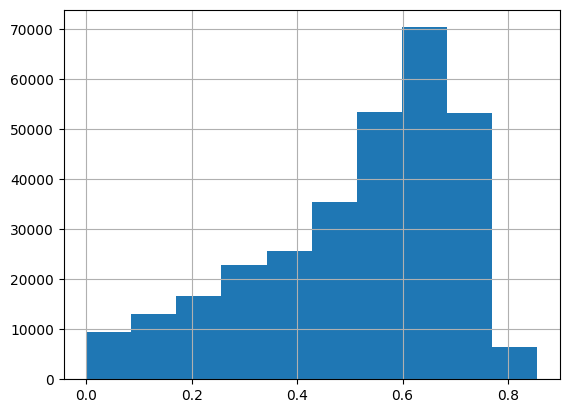

In [27]:
# Check EXT_SOURCE_2 distribution

train_app['EXT_SOURCE_2'].hist()

*Data is left skewed, will use median to impute*

**Need to add the EXT_SOURCE_2 column to the 0 nulls dataset**

In [28]:
# Create dataframe with EXT_SOURCE_2 and SK_ID_CURR for merge

ext_2col = train_app[['SK_ID_CURR', 'EXT_SOURCE_2']]
ext_2col.head()

,SK_ID_CURR,EXT_SOURCE_2
0,100002,0.262949
1,100003,0.622246
2,100004,0.555912
3,100006,0.650442
4,100007,0.322738


In [29]:
# Merge EXT_SOURCE_2 with train_0null

train_df = pd.merge(train_0null_df, ext_2col, how='inner', on='SK_ID_CURR')
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_ANNUITY,EXT_SOURCE_2
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,...,0,0,0,0,0,0,0,0,24700.5,0.262949
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,...,0,0,0,0,0,0,0,0,35698.5,0.622246
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,...,0,0,0,0,0,0,0,0,6750.0,0.555912
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,...,0,0,0,0,0,0,0,0,29686.5,0.650442
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,...,0,0,0,0,0,0,0,0,21865.5,0.322738


_**Completed Train set analysis, moving on to other datasets**_

## Bureau

* The remaining sheets, including this one, contains information for both train and test loans so need to be very careful about how these are analyzed and merged
* All client's previous credits provided by other financial institutions that were reported to Credit Bureau 
* One to many relationship
  * Primary key is also SK_ID_CURR but there are many different rows with this primary key
  * SK_BUREAU_ID is the identifier for each credit at the credit bureau
  * Will need to have one row per SK_ID_CURR for merge
* Aggregated by DAYS_CREDIT_UPDATE closest to 0
  * This means the row with the most recent credit data is the one keptfor each SK_ID_CURR

### *General Analysis*

In [30]:
# Import bureau spreadsheet

bureau = pd.read_csv('Data/Raw_Data/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


**I want to make a correlation list between the target and the items on the bureau list to determine what to tackle first**

In [31]:
# Split SKID and target off from train sheet to use for correlations

SKID_target = train_app[['SK_ID_CURR', 'TARGET']]
SKID_target.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


In [32]:
# Combine bureau data and target column - used inner combine to keep only values from train set

bureau_w_targ = pd.merge(bureau, SKID_target, how='inner', on='SK_ID_CURR')
bureau_w_targ.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,0
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,0


In [33]:
# Check for duplicate rows

print(f'Duplicates in bureau/target - {bureau_w_targ.duplicated().sum()}')

Duplicates in bureau/target - 0


In [34]:
# Check correlation with target and missing % of features

abs_corr(bureau_w_targ, 'TARGET')

,Correlation,Missing Percentage
TARGET,1.000000,0.000000
DAYS_CREDIT,0.061556,0.000000
DAYS_CREDIT_UPDATE,0.041076,0.000000
DAYS_ENDDATE_FACT,0.039057,0.371708
DAYS_CREDIT_ENDDATE,0.026497,0.060804
AMT_CREDIT_SUM,0.010606,0.000002
SK_ID_BUREAU,0.009018,0.000000
AMT_CREDIT_SUM_OVERDUE,0.006253,0.000000
AMT_CREDIT_SUM_LIMIT,0.005990,0.334172
SK_ID_CURR,0.003024,0.000000


**Most features have 0 nulls but the ones that do have more than 10% null. Will proceed with only those that have 0 nulls**

In [35]:
# Filter to show only columns with 0 null

bureau0_null = bureau.isna().sum() == 0
bureau0_null_df = bureau.loc[:, bureau0_null]
print(f'Nulls in bureau filtered set - {bureau0_null_df.isna().sum().sum()}')
print(f'Bureau shape is - {bureau.shape}')
print(f'Bureau 0 null shape is {bureau0_null_df.shape}')

Nulls in bureau filtered set - 0
Bureau shape is - (1716428, 17)
Bureau 0 null shape is (1716428, 10)


**Seven columns were dropped**

#### DAYS_CREDIT

* How many days before current application did client apply for Credit Bureau credit
* 0 nulls
* Will use a derivative of this for an engineered feature

**I want to check on the relationship between DAYS_CREDIT and the target. This has the largest correlation with the target of this dataset, though it is fairly close to 0**

_**The assumption I'm making is that people who applied for other types of credit very close to the day they applied for the home loan may be taking out many different loans at once and might be getting in over their heads. I will analyze a extra to see if this is true**_

In [36]:
# Look at range of values

bureau0_null_df['DAYS_CREDIT'].describe().apply(lambda x: f'{x:.6f}')

count    1716428.000000
mean       -1142.107685
std          795.164928
min        -2922.000000
25%        -1666.000000
50%         -987.000000
75%         -474.000000
max            0.000000
Name: DAYS_CREDIT, dtype: object

In [37]:
# Create separate table with DAYS_CREDIT, TARGET and SKID CURR

days_credit = bureau0_null_df[['DAYS_CREDIT', 'SK_ID_CURR']]

# Merge with target table, inner merge to look at only train

days_credit = pd.merge(days_credit, SKID_target, how='inner', on='SK_ID_CURR')

# Filter table to only show rows with the most recent (closest to 0) number on DAYS_CREDIT. This will show the most recent credit application for each client

days_credit = days_credit.loc[days_credit.groupby('SK_ID_CURR')['DAYS_CREDIT'].idxmax()]

days_credit.head()


,DAYS_CREDIT,SK_ID_CURR,TARGET
560271,-103,100002,1
870134,-606,100003,0
297397,-408,100004,0
1275813,-1149,100007,0
601360,-78,100008,0


In [38]:
# Check range of values

days_credit['DAYS_CREDIT'].describe()

count    263491.000000
mean       -489.297817
std         537.574145
min       -2922.000000
25%        -620.000000
50%        -300.000000
75%        -143.000000
max           0.000000
Name: DAYS_CREDIT, dtype: float64

In [39]:
# Bins need numbers listed monotonically and I want to sort values as we read them (i.e. 0 thru inf listed left to right), make an abs val column for the bins

days_credit['DAYS_CREDIT_ABS'] = days_credit['DAYS_CREDIT'].abs()
days_credit.head()

,DAYS_CREDIT,SK_ID_CURR,TARGET,DAYS_CREDIT_ABS
560271,-103,100002,1,103
870134,-606,100003,0,606
297397,-408,100004,0,408
1275813,-1149,100007,0,1149
601360,-78,100008,0,78


In [40]:
# Binned values look better on a chart for binary variables, make bins and add columns

dc_bins = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 5000]
dc_labels = ['0-250', '251-500','501-750','751-1000', '1001-1250', '1251-1500', '1501-1750', '1751-2000', '2001-2250', '2251-2500','2501-2750', 'More than 2750']

# Add column to dataset

days_credit['DAYS_CREDIT_BINS'] = pd.cut(days_credit['DAYS_CREDIT_ABS'], bins=dc_bins, labels=dc_labels, right=True)
days_credit.head()

,DAYS_CREDIT,SK_ID_CURR,TARGET,DAYS_CREDIT_ABS,DAYS_CREDIT_BINS
560271,-103,100002,1,103,0-250
870134,-606,100003,0,606,501-750
297397,-408,100004,0,408,251-500
1275813,-1149,100007,0,1149,1001-1250
601360,-78,100008,0,78,0-250


**I want to show the average default rate for each bin**

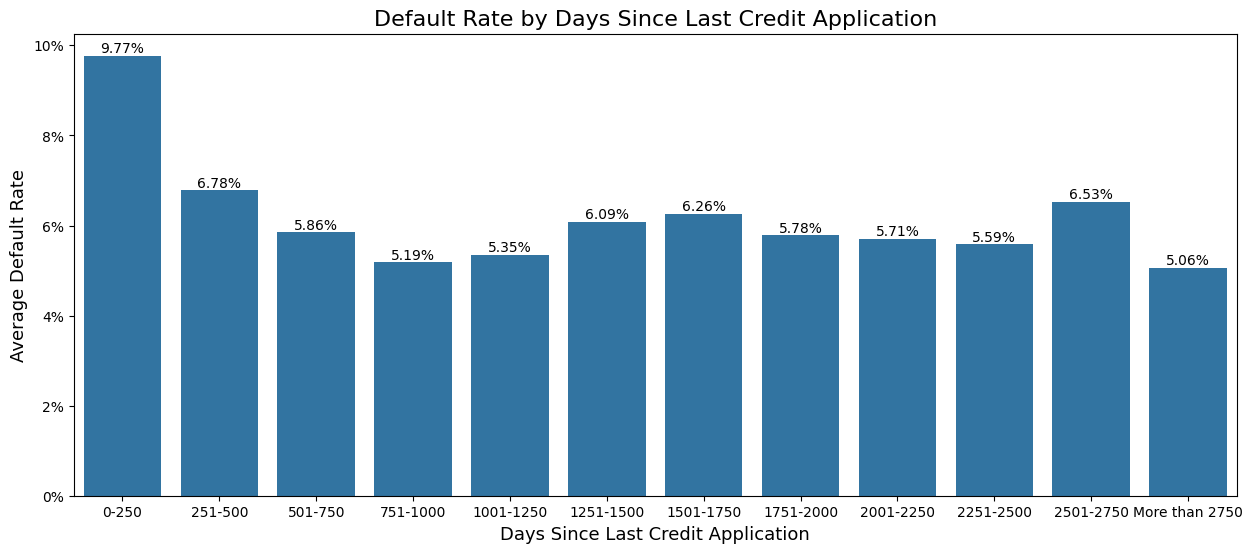

In [41]:
# Create figure

plt.figure(figsize=(15, 6))

ax_dc = sns.barplot(data=days_credit, x='DAYS_CREDIT_BINS', y='TARGET', estimator = 'mean', errorbar=None)
plt.xlabel('Days Since Last Credit Application', fontsize=13)
plt.ylabel('Average Default Rate', fontsize=13)
plt.title('Default Rate by Days Since Last Credit Application', fontsize=16)
for p in ax_dc.patches:  # Iterate over the bars
    ax_dc.annotate(f'{p.get_height() * 100:.2f}%', # Y-value display
                (p.get_x() + p.get_width() / 2, p.get_height()), # calculate center of bar
                ha='center', va='center', # Align the text at the center
                xytext=(0, 5), # Offset the text above the bar
                textcoords='offset points', # Use points to move the text
                fontsize=10, color='black') # Adjust text appearance

perc_formatter = ticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%')
ax_dc.yaxis.set_major_formatter(perc_formatter)

plt.tight_layout

plt.show()

**There is a slight increase in default rate as the bins get closer to application day, but only within 500 days. 251 to 500 is barely larger than the other later bins**

_**I want to break down by smaller bins 250 days and under to see if there is any obvious trend within that range**_

In [42]:
# Bin in increments of 25 days for days under 250, and have one bin for more than 250

# Create boundaries for bins

dc_bins2 = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 5000]

# Create labels for bins

dc_labels2 = ['0-25', '26-50', '51-75', '76-100', '101-125', '126-150', '151-175', '176-200', '201-225', '226-250', 'More than 250']

days_credit['DAYS_CREDIT_BINS2'] = pd.cut(days_credit['DAYS_CREDIT_ABS'], bins=dc_bins2, labels=dc_labels2, right=True)
days_credit.head()

,DAYS_CREDIT,SK_ID_CURR,TARGET,DAYS_CREDIT_ABS,DAYS_CREDIT_BINS,DAYS_CREDIT_BINS2
560271,-103,100002,1,103,0-250,101-125
870134,-606,100003,0,606,501-750,More than 250
297397,-408,100004,0,408,251-500,More than 250
1275813,-1149,100007,0,1149,1001-1250,More than 250
601360,-78,100008,0,78,0-250,76-100


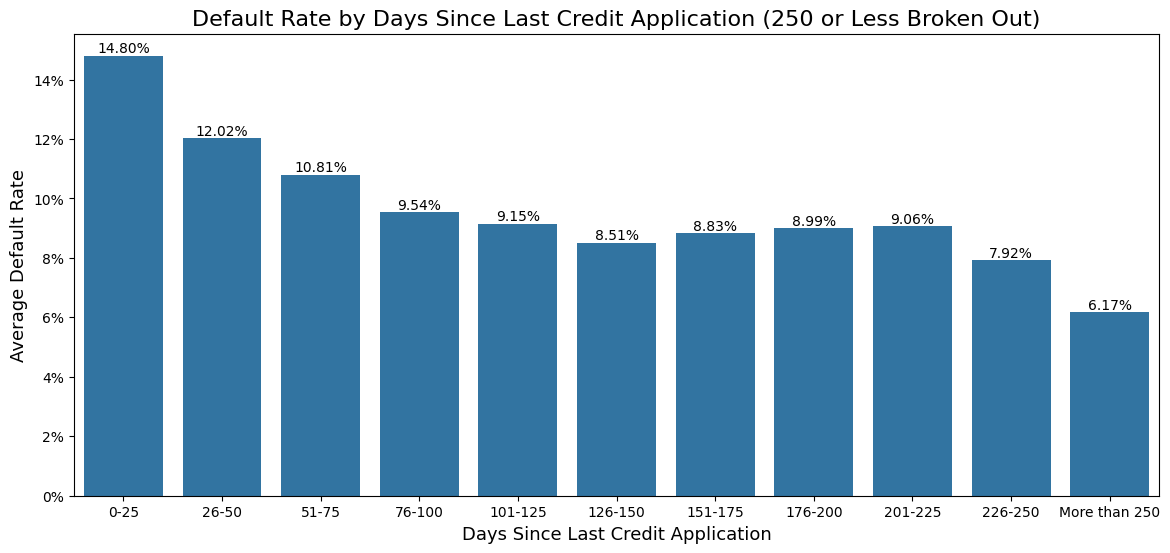

In [43]:
# Create figure showing default rate for each under 250 bin

plt.figure(figsize=(14, 6))

ax_dc2 = sns.barplot(data=days_credit, x='DAYS_CREDIT_BINS2', y='TARGET', estimator = 'mean', errorbar=None)
plt.xlabel('Days Since Last Credit Application', fontsize=13)
plt.ylabel('Average Default Rate', fontsize=13)
plt.title('Default Rate by Days Since Last Credit Application (250 or Less Broken Out)', fontsize=16)
for p in ax_dc2.patches:  # Iterate over the bars (patches)
    ax_dc2.annotate(f'{p.get_height() * 100:.2f}%',  # Y-value display
                (p.get_x() + p.get_width() / 2, p.get_height()),  # calculate center of bar
                ha='center', va='center',  # Align the text at the center
                xytext=(0, 5),  # Offset the text above the bar
                textcoords='offset points',  # Use points to move the text
                fontsize=10, color='black')  # Adjust text appearance

perc_formatter = ticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%')
ax_dc2.yaxis.set_major_formatter(perc_formatter)

plt.tight_layout

plt.show()

**Every bin until 226-250 shows a higher default rate than the sample average, and there is a clear trend**

_**I will check how many values are in each bin, and if they are sufficient I will use as an engineered feature**_

In [44]:
# Check value counts

days_credit['DAYS_CREDIT_BINS2'].value_counts()

DAYS_CREDIT_BINS2
More than 250    149360
76-100            13480
101-125           13126
126-150           12509
176-200           11912
51-75             11900
151-175           11660
26-50             11561
201-225           10837
226-250           10130
0-25               7012
Name: count, dtype: int64

**I will use DAYS_CREDIT_BINS2 - which has 250 days and less broken down - as an engineered feature**

_**Add BINS2 to bureau sheet, separately from the dataset above to avoid data leakage or target leakage**_

In [45]:
# Make set with only most recent days_credit

bureau_days = bureau0_null_df.loc[bureau0_null_df.groupby('SK_ID_CURR')['DAYS_CREDIT'].idxmax()]
bureau_days.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
248489,100001,5896635,Active,currency 1,-49,0,0,0.0,Consumer credit,-16
675689,100002,6158909,Active,currency 1,-103,0,0,0.0,Credit card,-24
1024669,100003,5885880,Active,currency 1,-606,0,0,0.0,Credit card,-43
363105,100004,6829134,Closed,currency 1,-408,0,0,0.0,Consumer credit,-382
1421816,100005,6735202,Active,currency 1,-62,0,0,0.0,Consumer credit,-31


In [46]:
# Bins need numbers listed monotonically and I want to sort values as we read them (i.e. 0 thru inf listed left to right), make an abs val column for the bins

bureau_days['DAYS_CREDIT_ABS'] = bureau_days['DAYS_CREDIT'].abs()

In [47]:
# Create column in bureau sheet using bins from figures

bureau_days['MOST_RECENT'] = pd.cut(bureau_days['DAYS_CREDIT_ABS'], bins=dc_bins2, labels=dc_labels2, right=True)
bureau_days.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,DAYS_CREDIT_ABS,MOST_RECENT
248489,100001,5896635,Active,currency 1,-49,0,0,0.0,Consumer credit,-16,49,26-50
675689,100002,6158909,Active,currency 1,-103,0,0,0.0,Credit card,-24,103,101-125
1024669,100003,5885880,Active,currency 1,-606,0,0,0.0,Credit card,-43,606,More than 250
363105,100004,6829134,Closed,currency 1,-408,0,0,0.0,Consumer credit,-382,408,More than 250
1421816,100005,6735202,Active,currency 1,-62,0,0,0.0,Consumer credit,-31,62,51-75


**I will be aggregating these down by a different column. If the aggregation doesn't keep the most recent credit application date then I will lose the individual column, which I would like to keep as well**

_**I will make a separate column with the individual days and will ensure it is negative just like the original values**_

In [48]:
# Convert absolute values back to negative

bureau_days['DAYS_CREDIT_REC'] = bureau_days['DAYS_CREDIT_ABS'] * -1

In [49]:
# Create table to merge with special columns to merge

bureau_for_merge = bureau_days[['SK_ID_CURR', 'MOST_RECENT', 'DAYS_CREDIT_REC']]
bureau_for_merge.head()

,SK_ID_CURR,MOST_RECENT,DAYS_CREDIT_REC
248489,100001,26-50,-49
675689,100002,101-125,-103
1024669,100003,More than 250,-606
363105,100004,More than 250,-408
1421816,100005,51-75,-62


In [50]:
# Merge with bureau set and merge left to keep all SKIDs in bureau set

bureau0_null_df = pd.merge(bureau0_null_df, bureau_for_merge, how='left', on='SK_ID_CURR')
bureau0_null_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MOST_RECENT,DAYS_CREDIT_REC
0,215354,5714462,Closed,currency 1,-497,0,0,0.0,Consumer credit,-131,26-50,-43
1,215354,5714463,Active,currency 1,-208,0,0,0.0,Credit card,-20,26-50,-43
2,215354,5714464,Active,currency 1,-203,0,0,0.0,Consumer credit,-16,26-50,-43
3,215354,5714465,Active,currency 1,-203,0,0,0.0,Credit card,-16,26-50,-43
4,215354,5714466,Active,currency 1,-629,0,0,0.0,Consumer credit,-21,26-50,-43


#### DAYS CREDIT UPDATE

* How many days before loan application did last information about the Credit Bureau credit come
  * AKA the number closest to 0 is the most recent information from the credit bureau
* 0 nulls


I am operating under the assumption that more recent data is more relevant than older data  -- aka if aggregation is needed, I am assuming most recent data should be kept over stale data

In [62]:
# Look at range of values to determine meaning

bureau0_null_df['DAYS_CREDIT_UPDATE'].describe()

count   1716428.000000
mean       -593.748320
std         720.747312
min      -41947.000000
25%        -908.000000
50%        -395.000000
75%         -33.000000
max         372.000000
Name: DAYS_CREDIT_UPDATE, dtype: float64

This column cannot have both negative and positive numbers if it is number of days before loan application. They could be either/or, but not both

In [63]:
# How many positive and negative values in feature

print(f'Positive values in Bureau/DAYS_CREDIT_UPDATE is - {(bureau0_null_df['DAYS_CREDIT_UPDATE'] > 0).sum()}')
print(f'Negative values in Bureau/DAYS_CREDIT_UPDATE is - {(bureau0_null_df['DAYS_CREDIT_UPDATE'] < 0).sum()}')

Positive values in Bureau/DAYS_CREDIT_UPDATE is - 17
Negative values in Bureau/DAYS_CREDIT_UPDATE is - 1715806


### 17 values out of 1.7 million is a very small amount. Since there can't be both negative and positive days before loan application, I will assume the 17 positive values are in error and will change them to negative

In [64]:
bureau0_null_df['DAYS_CREDIT_UPDATE'] = (bureau0_null_df['DAYS_CREDIT_UPDATE'].abs()) * -1

In [65]:
bureau0_null_df['DAYS_CREDIT_UPDATE'].describe()

count   1716428.000000
mean       -593.749053
std         720.746708
min      -41947.000000
25%        -908.000000
50%        -395.000000
75%         -33.000000
max           0.000000
Name: DAYS_CREDIT_UPDATE, dtype: float64

In [66]:
#Now filter by SKID and the Days Credit update closest to 0

filtered_bur_0null = bureau0_null_df.loc[bureau0_null_df.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].idxmax()]

In [67]:
filtered_bur_0null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305811 entries, 248488 to 1010007
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   SK_ID_CURR              305811 non-null  int64   
 1   SK_ID_BUREAU            305811 non-null  int64   
 2   CREDIT_ACTIVE           305811 non-null  object  
 3   CREDIT_CURRENCY         305811 non-null  object  
 4   DAYS_CREDIT             305811 non-null  int64   
 5   CREDIT_DAY_OVERDUE      305811 non-null  int64   
 6   CNT_CREDIT_PROLONG      305811 non-null  int64   
 7   AMT_CREDIT_SUM_OVERDUE  305811 non-null  float64 
 8   CREDIT_TYPE             305811 non-null  object  
 9   DAYS_CREDIT_UPDATE      305811 non-null  int64   
 10  MOST_RECENT             305787 non-null  category
 11  DAYS_CREDIT_REC         305811 non-null  int64   
dtypes: category(1), float64(1), int64(7), object(3)
memory usage: 28.3+ MB


In [68]:
filtered_bur_0null.head(50)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MOST_RECENT,DAYS_CREDIT_REC
248488,100001,5896634,Active,currency 1,-559,0,0,0.000000,Consumer credit,-6,26-50,-49
1337779,100002,6158903,Active,currency 1,-1042,0,0,0.000000,Consumer credit,-7,101-125,-103
1024669,100003,5885880,Active,currency 1,-606,0,0,0.000000,Credit card,-43,More than 250,-606
363105,100004,6829134,Closed,currency 1,-408,0,0,0.000000,Consumer credit,-382,More than 250,-408
1421815,100005,6735201,Active,currency 1,-137,0,0,0.000000,Consumer credit,-11,51-75,-62
1503966,100007,5987200,Closed,currency 1,-1149,0,0,0.000000,Consumer credit,-783,More than 250,-1149
718762,100008,6491434,Active,currency 1,-78,0,0,0.000000,Consumer credit,-16,76-100,-78
1279724,100009,5651010,Active,currency 1,-411,0,0,0.000000,Consumer credit,-23,226-250,-239
1688696,100010,5576630,Active,currency 1,-1138,0,0,0.000000,Consumer credit,-18,More than 250,-1138
420735,100011,5741085,Closed,currency 1,-1315,0,0,0.000000,Consumer credit,-965,More than 250,-1309


In [69]:
bureau0_null_df['MOST_RECENT'].isna().sum()

np.int64(182)

In [70]:

# bur_overlap = test['SK_ID_CURR'].isin(filtered_bur_0null['SK_ID_CURR'])

# len(bur_overlap)

In [71]:
#How many unique values in bureau0_null_df before drop above

bureau0_null_df['SK_ID_CURR'].nunique()


305811

In [72]:
# doubel heclk, should be same number of Bureau IDs in the new dataset


filtered_bur_0null['SK_ID_BUREAU'].nunique()

305811

In [73]:
# test['SK_ID_CURR'].nunique()

## Explore columns remaining in bureau sheet for how to handle data


### CREDIT_ACTIVE

* 0 nulls
* 'Bad Debt' only has three rows but "Sold" has 648. Both types are "bad" so will consolidate into one column

In [74]:
filtered_bur_0null['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Active      233586
Closed       71574
Sold           648
Bad debt         3
Name: count, dtype: int64

In [75]:
# # How many bad debt did I lose in my merge? -- 18 only out of 300k rows

(bureau0_null_df['CREDIT_ACTIVE'] == 'Bad debt').sum()

np.int64(21)

In [76]:
filtered_bur_0null['CREDIT_ACTIVE'] = filtered_bur_0null['CREDIT_ACTIVE'].replace('Sold', 'Bad debt')

In [77]:
filtered_bur_0null['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Active      233586
Closed       71574
Bad debt       651
Name: count, dtype: int64

### CREDIT_CURRENCY

* 0 nulls
* Though a small number are not currency 1, not sure if those others have any value to model. Will consolidate down to two choices - category 1 and other

In [78]:
filtered_bur_0null['CREDIT_CURRENCY'].value_counts()

CREDIT_CURRENCY
currency 1    305700
currency 2        99
currency 3        11
currency 4         1
Name: count, dtype: int64

In [79]:
# What percentage of values are not currency 1 -- less than 0.1%

(filtered_bur_0null['CREDIT_CURRENCY'] != 'currency 1').sum() / len(filtered_bur_0null['CREDIT_CURRENCY'])

np.float64(0.00036296928495050865)

### Though a small number are not currency 1, it is possible that currency 1 vs non-currency 1 provides value to model. I will combine 2-4 into "other"

In [80]:
# Combine all non-currency 1 into "other"

filtered_bur_0null['CREDIT_CURRENCY'] = filtered_bur_0null['CREDIT_CURRENCY'].replace(['currency 2', 'currency 3', 'currency 4'], 'other')

In [81]:
# Work check

filtered_bur_0null['CREDIT_CURRENCY'].value_counts()

CREDIT_CURRENCY
currency 1    305700
other            111
Name: count, dtype: int64

## CREDIT_TYPE

* 0 nulls
* Handful of values (unknown, real estate, cash, equipment purchase, working capital, business development) have less than 50 answers or are redundant
* Will consolidate as follows due to overlap
  * Business Loan
    * Loan for business development
    * Loan for working capital replenishment
    * Loan for the purchase of equipment
  * Real Estate
    * Mortgage
    * Real Estate Loan
  * Unknown
    * Cash loan
    * Unknown type
    * Another type

In [82]:
filtered_bur_0null['CREDIT_TYPE'].value_counts()

CREDIT_TYPE
Consumer credit                           186003
Credit card                               103016
Car loan                                    7521
Mortgage                                    6739
Microloan                                   1996
Loan for business development                207
Another type of loan                         178
Loan for working capital replenishment        99
Unknown type of loan                          35
Real estate loan                               9
Cash loan (non-earmarked)                      4
Loan for the purchase of equipment             4
Name: count, dtype: int64

In [83]:
filtered_bur_0null['CREDIT_TYPE'] = filtered_bur_0null['CREDIT_TYPE'].replace({'Loan for business development': 'Business Loan',
                                                                                'Loan for working capital replenishment' : 'Business Loan',
                                                                                'Loan for the purchase of equipment' : 'Business Loan',
                                                                                'Mortgage': 'Real Estate',
                                                                                'Real estate loan' : 'Real Estate',
                                                                                'Cash loan (non-earmarked)': 'Unknown',
                                                                                'Unknown type of loan': 'Unknown',
                                                                                'Another type of loan' : 'Unknown'})

In [84]:
filtered_bur_0null['CREDIT_TYPE'].value_counts()

CREDIT_TYPE
Consumer credit    186003
Credit card        103016
Car loan             7521
Real Estate          6748
Microloan            1996
Business Loan         310
Unknown               217
Name: count, dtype: int64

In [85]:
# # Combine with train dataset

train_df = pd.merge(train_df, filtered_bur_0null, how='left', on='SK_ID_CURR')

In [86]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MOST_RECENT,DAYS_CREDIT_REC
0,100002,1,Cash loans,M,N,Y,0,202500.000000,406597.500000,Working,...,Active,currency 1,-1042.000000,0.000000,0.000000,0.000000,Consumer credit,-7.000000,101-125,-103.000000
1,100003,0,Cash loans,F,N,N,0,270000.000000,1293502.500000,State servant,...,Active,currency 1,-606.000000,0.000000,0.000000,0.000000,Credit card,-43.000000,More than 250,-606.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000000,135000.000000,Working,...,Closed,currency 1,-408.000000,0.000000,0.000000,0.000000,Consumer credit,-382.000000,More than 250,-408.000000
3,100006,0,Cash loans,F,N,Y,0,135000.000000,312682.500000,Working,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000000,513000.000000,Working,...,Closed,currency 1,-1149.000000,0.000000,0.000000,0.000000,Consumer credit,-783.000000,More than 250,-1149.000000


## Moving on to new sheet

In [87]:
bur_bal = pd.read_csv('Data/Raw Data/bureau_Balance.csv')
bur_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [88]:
bur_bal.isna().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [89]:
bur_bal.duplicated().sum()

np.int64(0)

In [90]:
bur_bal['MONTHS_BALANCE'].value_counts()

MONTHS_BALANCE
-1     622601
-2     619243
-3     615080
 0     610965
-4     609138
        ...  
-92     57300
-93     53535
-94     49965
-95     46542
-96     43147
Name: count, Length: 97, dtype: int64

In [91]:
filtered_balance = bur_bal.loc[bur_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()]

In [92]:
filtered_balance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 817395 entries, 26079753 to 23544003
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   SK_ID_BUREAU    817395 non-null  int64 
 1   MONTHS_BALANCE  817395 non-null  int64 
 2   STATUS          817395 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.9+ MB


In [93]:
filtered_balance.nunique()

SK_ID_BUREAU      817395
MONTHS_BALANCE        97
STATUS                 8
dtype: int64

In [94]:
filtered_balance['STATUS'].value_counts()

STATUS
C    449603
X    203003
0    157328
1      5768
5      1258
2       286
3        86
4        63
Name: count, dtype: int64

In [95]:
train_overlap = train_df['SK_ID_BUREAU'].isin(filtered_balance['SK_ID_BUREAU'])

train_overlap.sum()

np.int64(92151)

In [96]:
train_df = pd.merge(train_df, filtered_balance, how='left', on='SK_ID_BUREAU')

In [97]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,DAYS_CREDIT,CREDIT_DAY_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MOST_RECENT,DAYS_CREDIT_REC,MONTHS_BALANCE,STATUS
0,100002,1,Cash loans,M,N,Y,0,202500.000000,406597.500000,Working,...,-1042.000000,0.000000,0.000000,0.000000,Consumer credit,-7.000000,101-125,-103.000000,-19.000000,C
1,100003,0,Cash loans,F,N,N,0,270000.000000,1293502.500000,State servant,...,-606.000000,0.000000,0.000000,0.000000,Credit card,-43.000000,More than 250,-606.000000,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.000000,135000.000000,Working,...,-408.000000,0.000000,0.000000,0.000000,Consumer credit,-382.000000,More than 250,-408.000000,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.000000,312682.500000,Working,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000000,513000.000000,Working,...,-1149.000000,0.000000,0.000000,0.000000,Consumer credit,-783.000000,More than 250,-1149.000000,NaN,NaN


In [98]:
# train_df.to_csv('2cleaned_LRBALC_w_Balance.csv', index=False)

In [99]:
train_df.shape

(307511, 70)

In [100]:
train_df.isna().sum().sum()

np.int64(915616)

In [101]:
prev = pd.read_csv('Data/Raw Data/previous_application.csv')

In [102]:
import pdb

In [103]:
prev.head()


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430000,17145.000000,17145.000000,0.000000,17145.000000,SATURDAY,15,...,Connectivity,12.000000,middle,POS mobile with interest,365243.000000,-42.000000,300.000000,-42.000000,-37.000000,0.000000
1,2802425,108129,Cash loans,25188.615000,607500.000000,679671.000000,NaN,607500.000000,THURSDAY,11,...,XNA,36.000000,low_action,Cash X-Sell: low,365243.000000,-134.000000,916.000000,365243.000000,365243.000000,1.000000
2,2523466,122040,Cash loans,15060.735000,112500.000000,136444.500000,NaN,112500.000000,TUESDAY,11,...,XNA,12.000000,high,Cash X-Sell: high,365243.000000,-271.000000,59.000000,365243.000000,365243.000000,1.000000
3,2819243,176158,Cash loans,47041.335000,450000.000000,470790.000000,NaN,450000.000000,MONDAY,7,...,XNA,12.000000,middle,Cash X-Sell: middle,365243.000000,-482.000000,-152.000000,-182.000000,-177.000000,1.000000
4,1784265,202054,Cash loans,31924.395000,337500.000000,404055.000000,NaN,337500.000000,THURSDAY,9,...,XNA,24.000000,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# Calculate number of applications per SK ID CURR

prev_app_count = prev.groupby('SK_ID_CURR')['SK_ID_PREV'].count().reset_index()
prev_app_count = prev_app_count.rename(columns={'SK_ID_PREV' : 'PREV_APP_COUNT'})
prev_app_count.head()

,SK_ID_CURR,PREV_APP_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [105]:
prev = pd.merge(prev, prev_app_count, how='left', on='SK_ID_CURR')

In [106]:
# Look at correlation between target and number of applications

app_count_target = pd.merge(SKID_target, prev_app_count, how='inner', on = 'SK_ID_CURR')
app_count_target.head()

,SK_ID_CURR,TARGET,PREV_APP_COUNT
0,100002,1,1
1,100003,0,3
2,100004,0,1
3,100006,0,9
4,100007,0,6


In [107]:
app_count_target.describe()

,SK_ID_CURR,TARGET,PREV_APP_COUNT
count,291057.000000,291057.000000,291057.000000
mean,278217.760487,0.081926,4.857128
std,102836.701610,0.274252,4.147042
min,100002.000000,0.000000,1.000000
25%,189156.000000,0.000000,2.000000
50%,278311.000000,0.000000,4.000000
75%,367278.000000,0.000000,6.000000
max,456255.000000,1.000000,73.000000


In [108]:
bins = [0, 10, 20, 30, 40, 100]
labels = ['0-10', '11-20', '21-30', '31-40', 'Above 40']

app_count_target['PREV_APP_BINS'] = pd.cut(app_count_target['PREV_APP_COUNT'], bins=bins, labels=labels, right=True)

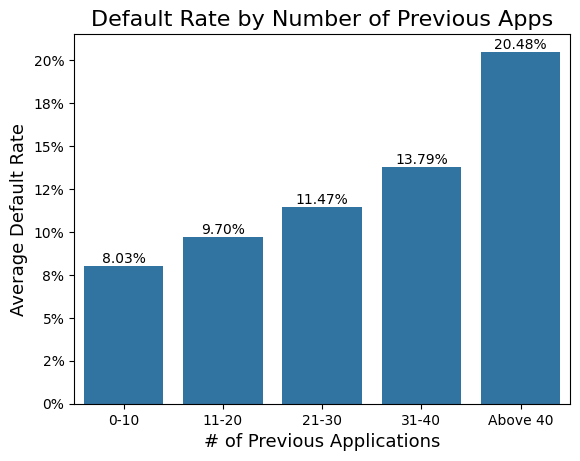

In [109]:
ax = sns.barplot(data=app_count_target, x='PREV_APP_BINS', y='TARGET', estimator = 'mean', errorbar=None)
plt.xlabel('# of Previous Applications', fontsize=13)
plt.ylabel('Average Default Rate', fontsize=13)
plt.title('Default Rate by Number of Previous Apps', fontsize=16)
for p in ax.patches:  # Iterate over the bars (patches)
    ax.annotate(f'{p.get_height() * 100:.2f}%',  # Text to display (y-value of the bar)
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position (center of the bar)
                ha='center', va='center',  # Align the text at the center
                xytext=(0, 5),  # Offset the text above the bar
                textcoords='offset points',  # Use points to move the text
                fontsize=10, color='black')  # Adjust text appearance

perc_formatter = ticker.FuncFormatter(lambda x, _: f'{x * 100:.0f}%')
ax.yaxis.set_major_formatter(perc_formatter)

plt.tight_layout

plt.show()

# y label above bars and remove error bars value counts

In [110]:
app_count_target['PREV_APP_BINS'].value_counts()

PREV_APP_BINS
0-10        265552
11-20        23004
21-30         2128
31-40          290
Above 40        83
Name: count, dtype: int64

In [111]:
prev['PREV_APP_BINS'] = pd.cut(prev['PREV_APP_COUNT'], bins=bins, labels=labels, right=True)

In [112]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 39 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   SK_ID_PREV                   1670214 non-null  int64   
 1   SK_ID_CURR                   1670214 non-null  int64   
 2   NAME_CONTRACT_TYPE           1670214 non-null  object  
 3   AMT_ANNUITY                  1297979 non-null  float64 
 4   AMT_APPLICATION              1670214 non-null  float64 
 5   AMT_CREDIT                   1670213 non-null  float64 
 6   AMT_DOWN_PAYMENT             774370 non-null   float64 
 7   AMT_GOODS_PRICE              1284699 non-null  float64 
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object  
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64   
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object  
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64   
 12  RATE_DOWN_PAYMENT           

In [113]:
prev.isna().sum().sort_values(ascending=False)

RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
AMT_DOWN_PAYMENT                895844
RATE_DOWN_PAYMENT               895844
NAME_TYPE_SUITE                 820405
NFLAG_INSURED_ON_APPROVAL       673065
DAYS_TERMINATION                673065
DAYS_FIRST_DRAWING              673065
DAYS_FIRST_DUE                  673065
DAYS_LAST_DUE_1ST_VERSION       673065
DAYS_LAST_DUE                   673065
AMT_GOODS_PRICE                 385515
AMT_ANNUITY                     372235
CNT_PAYMENT                     372230
PRODUCT_COMBINATION                346
AMT_CREDIT                           1
SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_APPLICATION                      0
FLAG_LAST_APPL_PER_CONTRACT          0
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
NAME_GOODS_CATEGORY                  0
NAME_CLIENT_TYPE                     0
CODE_REJECT_REASON       

In [114]:
prev_0null = prev.isna().sum() == 0

In [115]:
prev_0null_df = prev.loc[:, prev_0null]

In [116]:
prev_0null_df.isna().sum().sort_values(ascending=False)

SK_ID_PREV                     0
SK_ID_CURR                     0
NAME_CONTRACT_TYPE             0
AMT_APPLICATION                0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
FLAG_LAST_APPL_PER_CONTRACT    0
NFLAG_LAST_APPL_IN_DAY         0
NAME_CASH_LOAN_PURPOSE         0
NAME_CONTRACT_STATUS           0
DAYS_DECISION                  0
NAME_PAYMENT_TYPE              0
CODE_REJECT_REASON             0
NAME_CLIENT_TYPE               0
NAME_GOODS_CATEGORY            0
NAME_PORTFOLIO                 0
NAME_PRODUCT_TYPE              0
CHANNEL_TYPE                   0
SELLERPLACE_AREA               0
NAME_SELLER_INDUSTRY           0
NAME_YIELD_GROUP               0
PREV_APP_COUNT                 0
PREV_APP_BINS                  0
dtype: int64

In [117]:
prev_0null_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 23 columns):
 #   Column                       Non-Null Count    Dtype   
---  ------                       --------------    -----   
 0   SK_ID_PREV                   1670214 non-null  int64   
 1   SK_ID_CURR                   1670214 non-null  int64   
 2   NAME_CONTRACT_TYPE           1670214 non-null  object  
 3   AMT_APPLICATION              1670214 non-null  float64 
 4   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object  
 5   HOUR_APPR_PROCESS_START      1670214 non-null  int64   
 6   FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object  
 7   NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64   
 8   NAME_CASH_LOAN_PURPOSE       1670214 non-null  object  
 9   NAME_CONTRACT_STATUS         1670214 non-null  object  
 10  DAYS_DECISION                1670214 non-null  int64   
 11  NAME_PAYMENT_TYPE            1670214 non-null  object  
 12  CODE_REJECT_REASON          

CODE_REJECT_REASON

OHE


In [118]:
prev_0null_df['CODE_REJECT_REASON'].value_counts()

CODE_REJECT_REASON
XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: count, dtype: int64

FLAG_LAST_APPL_PER_CONTRACT


In [119]:
prev_0null_df['FLAG_LAST_APPL_PER_CONTRACT'].value_counts()

FLAG_LAST_APPL_PER_CONTRACT
Y    1661739
N       8475
Name: count, dtype: int64

NAME_CASH_LOAN_PURPOSE


In [120]:
prev_0null_df['NAME_CASH_LOAN_PURPOSE'].value_counts()

NAME_CASH_LOAN_PURPOSE
XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                          

In [121]:
prev_0null_df['NAME_CASH_LOAN_PURPOSE'] = prev_0null_df['NAME_CASH_LOAN_PURPOSE'].replace('Refusal to name the goal', 'Other')


C:\Users\nick_\AppData\Local\Temp\ipykernel_40748\3533590925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_0null_df['NAME_CASH_LOAN_PURPOSE'] = prev_0null_df['NAME_CASH_LOAN_PURPOSE'].replace('Refusal to name the goal', 'Other')


In [122]:
prev_0null_df['NAME_CASH_LOAN_PURPOSE'].value_counts()

NAME_CASH_LOAN_PURPOSE
XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15623
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                          

NAME_CLIENT_TYPE


In [123]:
prev_0null_df['NAME_CLIENT_TYPE'].value_counts()

NAME_CLIENT_TYPE
Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: count, dtype: int64

NAME_CONTRACT_STATUS


In [124]:
prev_0null_df['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64

NAME_GOODS_CATEGORY


In [125]:
prev_0null_df['NAME_GOODS_CATEGORY'].value_counts()

NAME_GOODS_CATEGORY
XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
Animals                          1
House Construction               1


In [126]:
prev_0null_df['NAME_GOODS_CATEGORY'] = prev_0null_df['NAME_GOODS_CATEGORY'].replace({'House Construction' : 'Construction Materials',
                                                                                     'Animals' : 'Other'})

C:\Users\nick_\AppData\Local\Temp\ipykernel_40748\1143791517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_0null_df['NAME_GOODS_CATEGORY'] = prev_0null_df['NAME_GOODS_CATEGORY'].replace({'House Construction' : 'Construction Materials',


In [127]:
prev_0null_df['NAME_GOODS_CATEGORY'].value_counts()

NAME_GOODS_CATEGORY
XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24996
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2555
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
Name: count, dtype: int64

NAME_PAYMENT_TYPE


In [128]:
prev_0null_df['NAME_PAYMENT_TYPE'].value_counts()

NAME_PAYMENT_TYPE
Cash through the bank                        1033552
XNA                                           627384
Non-cash from your account                      8193
Cashless from the account of the employer       1085
Name: count, dtype: int64

NAME_PORTFOLIO


In [129]:
prev_0null_df['NAME_PORTFOLIO'].value_counts()


NAME_PORTFOLIO
POS      691011
Cash     461563
XNA      372230
Cards    144985
Cars        425
Name: count, dtype: int64

In [130]:
prev_0null_df['NAME_PORTFOLIO'] = prev_0null_df['NAME_PORTFOLIO'].replace('Cars', 'Cards')

C:\Users\nick_\AppData\Local\Temp\ipykernel_40748\3415324158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_0null_df['NAME_PORTFOLIO'] = prev_0null_df['NAME_PORTFOLIO'].replace('Cars', 'Cards')


In [131]:
prev_0null_df['NAME_PORTFOLIO'].value_counts()


NAME_PORTFOLIO
POS      691011
Cash     461563
XNA      372230
Cards    145410
Name: count, dtype: int64

NAME_PRODUCT_TYPE


In [132]:
prev_0null_df['NAME_PRODUCT_TYPE'].value_counts()


NAME_PRODUCT_TYPE
XNA        1063666
x-sell      456287
walk-in     150261
Name: count, dtype: int64

NAME_SELLER_INDUSTRY


In [133]:
prev_0null_df['NAME_SELLER_INDUSTRY'].value_counts()

NAME_SELLER_INDUSTRY
XNA                     855720
Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: count, dtype: int64

NAME_YIELD_GROUP


In [134]:
prev_0null_df['NAME_YIELD_GROUP'].value_counts()

NAME_YIELD_GROUP
XNA           517215
middle        385532
high          353331
low_normal    322095
low_action     92041
Name: count, dtype: int64

CHANNEL_TYPE


In [135]:
prev_0null_df['CHANNEL_TYPE'].value_counts()

CHANNEL_TYPE
Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: count, dtype: int64

NAME_CONTRACT_TYPE


In [136]:
prev_0null_df.rename(columns={'NAME_CONTRACT_TYPE' :'PREV_NAME_CONTRACT_TYPE'}, inplace=True)

C:\Users\nick_\AppData\Local\Temp\ipykernel_40748\3363848279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_0null_df.rename(columns={'NAME_CONTRACT_TYPE' :'PREV_NAME_CONTRACT_TYPE'}, inplace=True)


In [137]:
filt_prev_0null_df = prev_0null_df.loc[prev_0null_df.groupby('SK_ID_CURR')['DAYS_DECISION'].idxmax()]

In [138]:
filt_prev_0null_df.shape

(338857, 23)

In [139]:
filt_prev_0null_df['SK_ID_CURR'].nunique()

338857

In [140]:
filt_prev_0null_df['SK_ID_PREV'].nunique()

338857

In [141]:
train_df = pd.merge(train_df, filt_prev_0null_df, how="left", on='SK_ID_CURR')

In [142]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 92 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   SK_ID_CURR                    307511 non-null  int64   
 1   TARGET                        307511 non-null  int64   
 2   NAME_CONTRACT_TYPE            307511 non-null  object  
 3   CODE_GENDER                   307511 non-null  object  
 4   FLAG_OWN_CAR                  307511 non-null  object  
 5   FLAG_OWN_REALTY               307511 non-null  object  
 6   CNT_CHILDREN                  307511 non-null  int64   
 7   AMT_INCOME_TOTAL              307511 non-null  float64 
 8   AMT_CREDIT                    307511 non-null  float64 
 9   NAME_INCOME_TYPE              307511 non-null  object  
 10  NAME_EDUCATION_TYPE           307511 non-null  object  
 11  NAME_FAMILY_STATUS            307511 non-null  object  
 12  NAME_HOUSING_TYPE             

In [162]:
train_df.to_csv('Data/Raw_Data/Filtered_Train_App.csv', index=False)

In [144]:
test = pd.read_csv('Data/Raw Data/application_test.csv')

In [145]:
test = pd.merge(test, filtered_bur_0null, how='left', on = 'SK_ID_CURR')

In [146]:
test = pd.merge(test, filtered_balance, how='left', on='SK_ID_BUREAU')

In [147]:
test = pd.merge(test, filt_prev_0null_df, how='left', on='SK_ID_CURR')

In [148]:
test["SK_ID_CURR"].nunique()

48744

In [149]:

test_overlap = test['SK_ID_CURR'].isin(filt_prev_0null_df['SK_ID_CURR'])

test_overlap.sum()

np.int64(47800)

In [150]:
filt_prev_0null_df

,SK_ID_PREV,SK_ID_CURR,PREV_NAME_CONTRACT_TYPE,AMT_APPLICATION,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PREV_APP_COUNT,PREV_APP_BINS
201668,1369693,100001,Consumer loans,24835.500000,FRIDAY,13,Y,1,XAP,Approved,...,Refreshed,Mobile,POS,XNA,Country-wide,23,Connectivity,high,1,0-10
892077,1038818,100002,Consumer loans,179055.000000,SATURDAY,9,Y,1,XAP,Approved,...,New,Vehicles,POS,XNA,Stone,500,Auto technology,low_normal,1,0-10
575941,1810518,100003,Cash loans,900000.000000,FRIDAY,12,Y,1,XNA,Approved,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,low_normal,3,0-10
935548,1564014,100004,Consumer loans,24282.000000,FRIDAY,5,Y,1,XAP,Approved,...,New,Mobile,POS,XNA,Regional / Local,30,Connectivity,middle,1,0-10
1259112,1857999,100005,Cash loans,0.000000,FRIDAY,10,Y,1,XNA,Canceled,...,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,XNA,2,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292302,2248017,456251,Consumer loans,40455.000000,THURSDAY,17,Y,1,XAP,Approved,...,New,Mobile,POS,XNA,Country-wide,30,Connectivity,high,1,0-10
444497,1503599,456252,Consumer loans,57595.500000,WEDNESDAY,10,Y,1,XAP,Approved,...,New,Consumer Electronics,POS,XNA,Country-wide,190,Consumer electronics,low_normal,1,0-10
181558,1686207,456253,Consumer loans,28912.500000,SATURDAY,12,Y,1,XAP,Approved,...,Refreshed,Mobile,POS,XNA,Stone,22,Connectivity,high,2,0-10
7315,2016407,456254,Consumer loans,223789.500000,SATURDAY,18,Y,1,XAP,Approved,...,Repeater,Computers,POS,XNA,Country-wide,3093,Consumer electronics,low_normal,2,0-10


In [151]:
bureau0_null_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 12 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   SK_ID_CURR              int64   
 1   SK_ID_BUREAU            int64   
 2   CREDIT_ACTIVE           object  
 3   CREDIT_CURRENCY         object  
 4   DAYS_CREDIT             int64   
 5   CREDIT_DAY_OVERDUE      int64   
 6   CNT_CREDIT_PROLONG      int64   
 7   AMT_CREDIT_SUM_OVERDUE  float64 
 8   CREDIT_TYPE             object  
 9   DAYS_CREDIT_UPDATE      int64   
 10  MOST_RECENT             category
 11  DAYS_CREDIT_REC         int64   
dtypes: category(1), float64(1), int64(7), object(3)
memory usage: 145.7+ MB


In [152]:
# test_df = pd.merge(test, bureau0_null_df, how='left', on='SK_ID_CURR')

In [153]:
# test_df = pd.merge(test, filt_prev_0null_df, how='left', on='SK_ID_CURR')

In [154]:
test['MOST_RECENT']

0                26-50
1                51-75
2        More than 250
3        More than 250
4                  NaN
             ...      
48739          101-125
48740              NaN
48741          201-225
48742    More than 250
48743    More than 250
Name: MOST_RECENT, Length: 48744, dtype: category
Categories (11, object): ['0-25' < '26-50' < '51-75' < '76-100' ... '176-200' < '201-225' < '226-250' < 'More than 250']

In [155]:
test.isna().sum()

SK_ID_CURR                0
NAME_CONTRACT_TYPE        0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
                       ... 
SELLERPLACE_AREA        944
NAME_SELLER_INDUSTRY    944
NAME_YIELD_GROUP        944
PREV_APP_COUNT          944
PREV_APP_BINS           944
Length: 156, dtype: int64

In [156]:
test.shape

(48744, 156)

In [157]:
test.to_csv('Data/Raw_Data/test_final.csv', index=False)